In [35]:
import numpy as np
from matplotlib import cm
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import sparse 
import seaborn as sns
sns.set(rc={'axes.facecolor':'#F5F5F5'})
%matplotlib inline

from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,maxabs_scale
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,NuSVC,SVR,NuSVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import neighbors
from sklearn.decomposition import TruncatedSVD

from time import time

# Importing data

In [2]:
# Function to load csr matrix of samples and list of colnames from file
def load_csr_from_csv(filename):
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    data = np.ones_like(indices,dtype=np.int8)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [3]:
# returns the csr matrix of samples and list of colnames
def load_csr_from_csv_with_data(filename):
    data = np.loadtxt(filename+"_data.csv",unpack=True,delimiter=",",dtype=np.int8)
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [18]:
# load the target values of brightness and create a binary vector 
# with 1 for samples with brightness above threshold and 0 otherwise
y,std = np.loadtxt("target_values.csv",unpack=True,delimiter=",")

threshold = 0.95 #threshold for target values

y_bin = np.where(y >= y[0]*threshold,1,0) # binary respresentation of target values based on threshold

class_weights = (y_bin.sum()*1./(y_bin.shape[0]-y_bin.sum())*1.,1.)
 
print "Total number of mutants: %d"%y.shape[0]
print "Fraction of positive samples: %.2f"%(y_bin.sum()*1./y_bin.shape[0])

Total number of mutants: 54025
Fraction of positive samples: 0.34


In [19]:
sample_weights = np.loadtxt("sample_weights.csv",delimiter=",")
sample_weights = np.log10(sample_weights*10)
sample_weights = (sample_weights/sample_weights.max()).reshape(-1)

In [51]:
# Load the full mutation list dataset with column names from file
X, col_names = load_csr_from_csv("sparse_csr")
print X.shape

(54025, 1879)


In [52]:
# Retrieve all the mutants with single mutations 
# and create the look up table for this single mutations
single_mutations = {}
single_mut_idx = []

for i in xrange(X.shape[0]):
    if X.getrow(i).indices.shape[0] == 1: #how many mutations in this mutant? one?
        index = X.getrow(i).indices[0]
        mutation = col_names[index]
#         print mutation, i
        if mutation not in single_mutations:
            single_mutations[mutation] = {"id":index,"mutants":[i]}
            single_mut_idx.append(i)
        else:
            single_mutations[mutation]["mutants"].append(i)

In [53]:
print "Total number of single mutation mutants: %d" % len(single_mut_idx)

Total number of single mutation mutants: 1114


# Extra trees classifier

In [54]:
print "Performing parameter grid search on Extra trees Classifier..."
t1 = time()
clf = ExtraTreesClassifier(n_estimators=30,class_weight={0:class_weights[0],1:class_weights[1]})
#print rf.get_params()
parameters = {"max_features":(10,"auto"),"min_samples_split":(50,)}
clf = GridSearchCV(clf, parameters,cv = 5,n_jobs=-1)#,fit_params={'sample_weight':sample_weights})
clf.fit(X,y_bin)
print "Time taken: %.2f"%(time()-t1)

Performing parameter grid search on Extra trees Classifier...
Time taken: 38.46


In [55]:
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score").sort_values(by="rank_test_score")
cv_results[['params',"mean_train_score","mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'max_features': 10, 'min_samples_split': 50} 0.82994909764


,params,mean_train_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,"{u'max_features': 10, u'min_samples_split': 50}",0.961828,0.829949,0.008079,1,16.392576
1,"{u'max_features': u'auto', u'min_samples_split...",0.957020,0.819250,0.009081,2,17.629419


In [56]:
yhat = clf.predict(X)
print "Training accuracy: %.2f"%metrics.accuracy_score(y_bin,yhat,sample_weight = sample_weights)

Training accuracy: 0.96


# Assessing quality

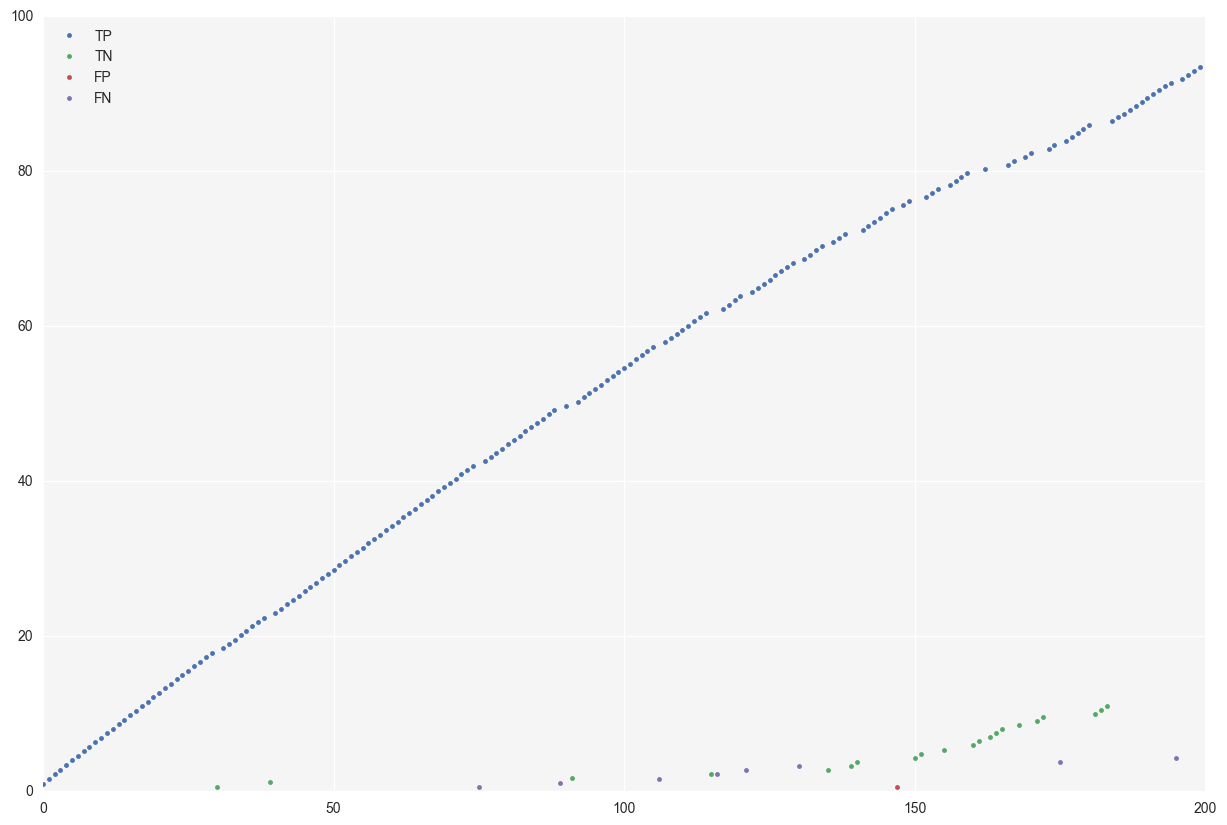

In [26]:
r = 200
x = np.arange(r)
weight_order = sample_weights.argsort()[::-1]

TP = (yhat == y_bin) & (y_bin == 1)
TP = TP[weight_order][:r]

TN = (yhat == y_bin) & (y_bin == 0)
TN = TN[weight_order][:r]

FP = (yhat != y_bin) & (yhat == 1)
FP = FP[weight_order][:r]

FN = (yhat != y_bin) & (yhat == 0)
FN = FN[weight_order][:r]

F = (yhat != y_bin)
F = F[weight_order][:r]

T = (yhat == y_bin)
T = T[weight_order][:r]

plt.figure(figsize = [15,10])
plt.plot(x[TP],sample_weights[weight_order][:r][TP].cumsum(),'.')
plt.plot(x[TN],sample_weights[weight_order][:r][TN].cumsum(),'.')
plt.plot(x[FP],sample_weights[weight_order][:r][FP].cumsum(),'.')
plt.plot(x[FN],sample_weights[weight_order][:r][FN].cumsum(),'.')
plt.legend(('TP','TN',"FP","FN"), loc = 2);

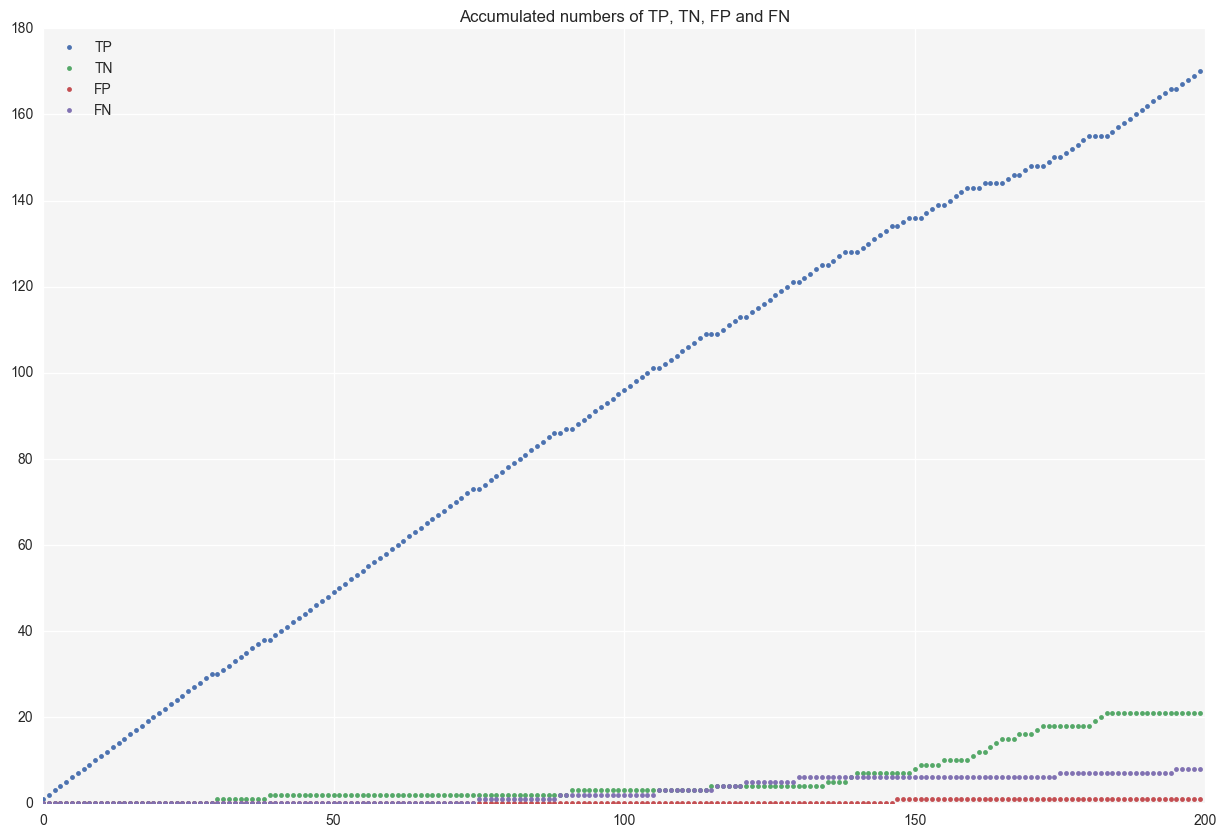

In [27]:
plt.figure(figsize = [15,10])
plt.plot(x,TP.cumsum(), '.')
plt.plot(x,TN.cumsum(), '.')
plt.plot(x,FP.cumsum(), '.')
plt.plot(x,FN.cumsum(), '.')
plt.legend(('TP','TN',"FP","FN"),loc=2)
plt.title('Accumulated numbers of TP, TN, FP and FN');

False predictions start at #75 sample weight


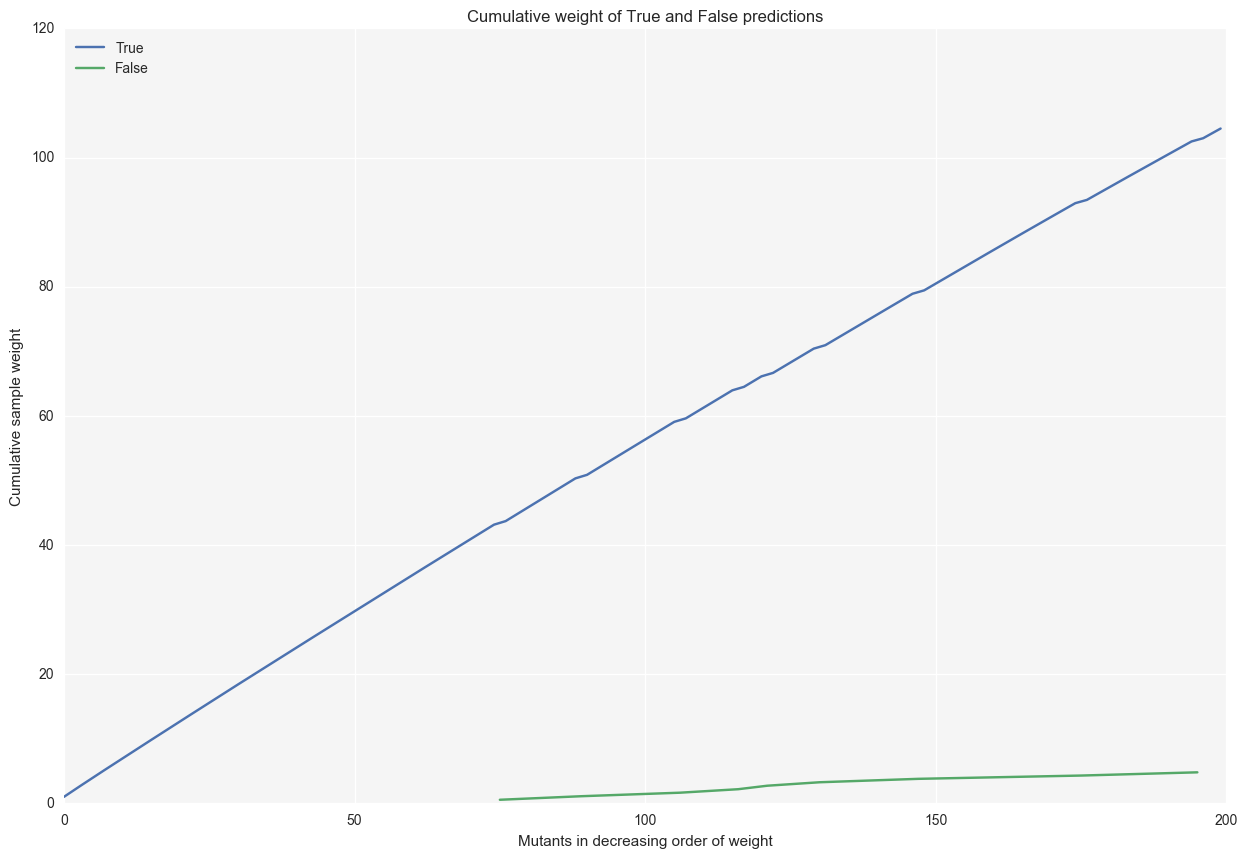

In [28]:
plt.figure(figsize=[15,10])
pT = plt.plot(x[T],sample_weights[weight_order][:r][T].cumsum())
pF = plt.plot(x[F],sample_weights[weight_order][:r][F].cumsum())
print 'False predictions start at #%d sample weight' % x[F][0]

plt.legend((pT[0], pF[0]), ('True','False'),loc=2)

plt.title("Cumulative weight of True and False predictions")
plt.ylabel("Cumulative sample weight")
plt.xlabel("Mutants in decreasing order of weight");

In [29]:
single_mutants_idx = np.asarray((np.sum(X,axis = 1) == 1)).ravel()
single_mutation_idx = np.asarray(np.sum(X[single_mutants_idx,:],axis=0) == 1).ravel()
single_mutation_idx
del single_mutants_idx

S = sparse.diags(np.ones(X.shape[1]))
hs = clf.predict_proba(S)
pos_idx = (hs[:,1]>0.9) & ~single_mutation_idx
neg_idx = (hs[:,0]>0.9) & ~single_mutation_idx
pos_mutations = zip([col_names[i] for i in xrange(pos_idx.shape[0]) if pos_idx[i]],hs[pos_idx][:,1],np.sum(X[:,pos_idx],axis = 0).tolist()[0])
neg_mutations = zip([col_names[i] for i in xrange(neg_idx.shape[0]) if neg_idx[i]],hs[neg_idx][:,0],np.sum(X[:,neg_idx],axis = 0).tolist()[0])
print len(pos_mutations),len(neg_mutations)

421 81
0.378038883209


# Generating code for PyMOL

bg_color white
set surface_quality, 1
set transparency, 0.5

fetch 2WUR 
show cartoon, all
hide lines, all

select waters, name o
hide everything, waters

select chr, resn GYS

color white, all
show sticks, chr
color green, chr

select aa_64_68, resi 64+68
select aa_64_68_mainchain, aa_64_68 and name C+CO+CA+N
show ribbons, aa_64_68_mainchain

In [390]:
positions = []
for m in pos_mutations[:100]:
    position = int(m[0][2:-1])
    positions.append(position)

In [391]:
for position in sorted(positions):
    color = cm.cool(10.0)
    colorName = "mCol" + str(position+2)
    selName = "mSel" + str(position+2)
    print '#' + str(position+2)
    print "set_color " + colorName + " = " +str(color[0:3])
    print "select " + selName +", resi " + str(int(position + 2))
    print "show spheres, " + selName
    print "color " + colorName + " ," + selName

#3
set_color mCol3 = (1.0, 0.0, 1.0)
select mSel3, resi 3
show spheres, mSel3
color mCol3 ,mSel3
#4
set_color mCol4 = (1.0, 0.0, 1.0)
select mSel4, resi 4
show spheres, mSel4
color mCol4 ,mSel4
#6
set_color mCol6 = (1.0, 0.0, 1.0)
select mSel6, resi 6
show spheres, mSel6
color mCol6 ,mSel6
#6
set_color mCol6 = (1.0, 0.0, 1.0)
select mSel6, resi 6
show spheres, mSel6
color mCol6 ,mSel6
#7
set_color mCol7 = (1.0, 0.0, 1.0)
select mSel7, resi 7
show spheres, mSel7
color mCol7 ,mSel7
#9
set_color mCol9 = (1.0, 0.0, 1.0)
select mSel9, resi 9
show spheres, mSel9
color mCol9 ,mSel9
#17
set_color mCol17 = (1.0, 0.0, 1.0)
select mSel17, resi 17
show spheres, mSel17
color mCol17 ,mSel17
#19
set_color mCol19 = (1.0, 0.0, 1.0)
select mSel19, resi 19
show spheres, mSel19
color mCol19 ,mSel19
#21
set_color mCol21 = (1.0, 0.0, 1.0)
select mSel21, resi 21
show spheres, mSel21
color mCol21 ,mSel21
#21
set_color mCol21 = (1.0, 0.0, 1.0)
select mSel21, resi 21
show spheres, mSel21
color mCol21 ,mSel21
#3

# Simultaneous mutations introduction

In [317]:
pos_mutations.sort(key=lambda x:x[2],reverse = True)
neg_mutations.sort(key=lambda x:x[2],reverse = True)
pos_mutations[:100]

[('SN210H', 0.98900530571079481, 79L),
 ('ST184I', 0.97283266209316177, 74L),
 ('SN103T', 0.98855658098215748, 39L),
 ('SD232A', 0.98716866857089325, 39L),
 ('SD171E', 0.93800635031541579, 36L),
 ('SK156T', 0.98700212771282092, 35L),
 ('SI227S', 0.92867705809644219, 34L),
 ('SK124T', 0.98359385591446624, 33L),
 ('SA152G', 0.97527841463459031, 31L),
 ('SD19E', 0.99052218705267026, 29L),
 ('SQ202K', 0.98088254840793276, 27L),
 ('SK154N', 0.98113061455457673, 26L),
 ('SQ182H', 0.97025305612210666, 26L),
 ('SR107L', 0.95178108044027843, 25L),
 ('SP87T', 0.92008646887212397, 25L),
 ('SD232E', 0.9964230705731032, 24L),
 ('SD19Y', 0.96744512846825093, 24L),
 ('SE233*', 0.93584844545053048, 24L),
 ('SD188E', 0.9974872917756108, 22L),
 ('SD188Y', 0.98435302130219993, 22L),
 ('SL219M', 0.97261067024463432, 22L),
 ('SI227L', 0.99439376874476204, 21L),
 ('SY235S', 0.9937737581345345, 20L),
 ('SG158A', 0.98847344375068014, 20L),
 ('SS206T', 0.98005686894078636, 20L),
 ('SK1N', 0.93349970012330297, 

In [319]:
pos_mutations_extracted = [mut[0] for mut in pos_mutations[:100]]
top_pos_idx = np.in1d(col_names, pos_mutations_extracted)

In [364]:
rows = 100000
test_X = np.zeros((rows, X.shape[1]))

In [365]:
x = np.arange((1879))
test_idx = x[top_pos_idx]

In [366]:
for it in range(rows):
    i = 0
    while i <= 20:
        i+=1
        x = np.random.randint(0,len(test_idx))
        test_X[it, test_idx[x]] = 1

In [367]:
hs = clf.predict_proba(test_X)

pos_idx = (hs[:,1]>0.9)
neg_idx = (hs[:,0]>0.9)
df = pd.DataFrame(test_X[pos_idx], columns=col_names)

In [368]:
pos_cum_mut = []
for i in range(len(df)):
    pos_cum_mut += list(df.columns[df.ix[i] == 1])

In [378]:
pos_cum_mut = list(set(pos_cum_mut))

In [386]:
x = np.arange((100))
x[~np.in1d(pos_mutations_extracted, pos_cum_mut)]

array([76, 97])

In [388]:
bad_mut = []
for i in [76, 97]:
    bad_mut += list(df.columns[df.ix[i] == 1])

In [389]:
bad_mut

['SQ202K',
 'SI227L',
 'SD171E',
 'SN210H',
 'SQ182H',
 'SK138G',
 'SI227A',
 'SE113Q',
 'SD19E',
 'SK156T',
 'SD19Y',
 'SE32Q',
 'SS173I',
 'SM151A',
 'SN133K',
 'SS145I',
 'SG172V',
 'SM231E',
 'SI227L',
 'SD188H',
 'SD171E',
 'SE233*',
 'SD232E',
 'SY180D',
 'SL123M',
 'SD19E',
 'SD19Y',
 'SE122D',
 'SG158A',
 'SQ182E',
 'SH79C',
 'SS173I',
 'SI169M',
 'SP54A',
 'SM231E',
 'ST7N']